# 3. Building and evaluating different models

#### Procedure
- Training data set (which has been embedded) will be run on different models 

Models to build:
- a dummy model: mean of y
- a baseline model: using only gender
- "full" models (including all predictors):
    - a simple linear regression
    - a non-parametric linear regression; KNN
    - a random forrest regressor

I expect that the data should be heavily regularized. I'll take care of that when I've found the most promising model. 

When the 'winning' model has been regularized and fine-tuned using cross-validation, the model will be tested on the validation set.

Then the model can be further tuned, before it is finally run on the test data set, and the results are reported.


In [1]:
# important packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error # MSE?? rmse? 
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## random forrest og feature importance 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
import pickle as pkl
import shap


/work/datascience_exam/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
# load data which has been embedded, clustered and dimensionality reduced using PCA
train = pd.read_csv('/work/datascience_exam/data/train_features.csv', index_col = 0)

X_train = train.iloc[:,:237] # all columns but the last one which is 'Age of Death'
y_train = train.loc[:,'Age of death']

In [30]:
# loading validation dataset
val = pd.read_csv('/work/datascience_exam/data/val_features.csv', index_col = 0)

X_val = val.iloc[:,:237] # all columns but the last one which is 'Age of Death'
y_val = val.loc[:,'Age of death']

In [31]:
# loading test data
test = pd.read_csv('/work/datascience_exam/data/test_features.csv', index_col = 0)

X_test = test.iloc[:,:237] # all columns but the last one which is 'Age of Death'
y_test = test.loc[:,'Age of death']

In [32]:
X_train.head()

,Gender_encode,Birth year,Occupation_cluster,country1,country2,country3,country4,country5,country6,country7,...,description143,description144,description145,description146,description147,description148,description149,description150,description151,description152
0,2,1915,1,-0.203594,-0.144200,0.094234,-0.186961,0.011282,-0.267115,0.042559,...,-0.002223,0.031173,-0.015610,0.021765,-0.043946,-0.055602,0.099160,0.005596,0.025316,0.010624
1,1,1915,0,-0.201265,-0.031549,0.048032,-0.224219,-0.395700,0.084482,-0.024386,...,0.010041,-0.029504,-0.007824,0.001081,0.023954,-0.006589,-0.006589,0.017155,-0.019700,-0.009435
2,1,1923,0,-0.273769,-0.121739,-0.152663,0.409265,-0.110530,0.146183,0.105975,...,-0.003499,0.002186,0.005657,0.013795,0.006256,-0.000399,0.004402,-0.004409,0.008620,0.000956
3,1,1918,2,-0.349983,-0.160185,-0.229322,-0.122732,0.266424,0.049163,-0.095842,...,0.011873,0.013108,-0.010277,-0.005705,0.001044,-0.009338,0.039861,0.008489,-0.014900,-0.028253
4,1,1856,3,-0.029722,0.303856,0.063169,-0.040947,0.083048,-0.158634,0.014466,...,0.027537,-0.052587,-0.002195,0.020234,0.008825,-0.071778,0.031260,0.011545,0.020523,0.016538


## Building models

I want to build the following models:

- Model 1: A 'dummy' model with only the mean of y as feature
- Model 2: A 'baseline' model 
    - one which only includes 'gender' as feature
    - one which only includes 'birth year' as feature
- Model 3: The full model which includes all predictors. 

Model 1 and 2 will be modelled as a linear regression. 

Model 3 will be modelled as a linear regression, KNN-regression and a random forrest.

In [43]:
performances = []

In [44]:
### Dummy model - PD version

mean_value = y_train.mean()

performance = np.sqrt(mean_squared_error(y_val, [mean_value]*len(y_val)))
r2 = r2_score(y_val, [mean_value]*len(y_val))
performances.append({'model': 'dummy',
                     'split': 'validation',
                     'rmse': performance.round(4),
                     'r2': r2.round(4)})

In [45]:
### Baseline model - only predictor is gender - linear regression - PD version

gender_train = X_train.loc[:, ['Gender_encode']]
gender_val = X_val.loc[:, ['Gender_encode']]

reg = LinearRegression().fit(gender_train, y_train)

preds =  reg.predict(gender_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'linear-gender',
                     'split': 'validation',
                     'rmse': performance.round(4),
                     'r2': r2.round(4)})

In [49]:
birth_year_train = X_train.loc[:, ['Birth year']]
birth_year_val = X_val.loc[:, ['Birth year']]

reg = LinearRegression().fit(birth_year_train, y_train)

preds =  reg.predict(birth_year_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'linear-birth_year',
                        'split': 'validation',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [51]:
### full linear model 

reg = LinearRegression().fit(X_train, y_train)

preds =  reg.predict(X_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'linear-full',
                         'split': 'validation',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [57]:
# linear lasso
reg = Lasso().fit(X_train, y_train)

preds = reg.predict(X_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'linear_lasso_alpha_1.0',
                         'split': 'validation',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [58]:
# linear ridge
reg = Ridge().fit(X_train, y_train)

preds = reg.predict(X_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'linear_ridge_alpha_1.0',
                         'split': 'validation',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [61]:
k = 10
neigh = KNeighborsRegressor(n_neighbors=k)
neigh.fit(X_train, y_train)

preds = neigh.predict(X_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': f'knn-allpreds-{k}',
                        'split': 'validation',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [62]:
# save model
pkl.dump(neigh, file=open(f'/work/datascience_exam/output/models/knn-allpreds-{k}.pkl', 'wb')) # save the model

In [21]:
# randomforest model with default parameter values - # 255 min in ucloud with all features

rfreg = RandomForestRegressor(random_state=42)
rfreg.fit(X_train, y_train) 

preds = rfreg.predict(X_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'randomforest_default_allpreds', # rfr_default (old name)
                        'split': 'validation',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [22]:
# save model 
#pkl.dump(rfreg, file=open(f'/work/datascience_exam/output/models/rfr_default_all_features.pkl', 'wb')) # save the model

In [64]:
# reload model 
rfreg = pkl.load(open('/work/datascience_exam/output/models/rfr_default_all_features.pkl','rb'))

In [66]:
print(*performances, sep = '\n')

{'model': 'dummy', 'split': 'validation', 'rmse': 15.9833, 'r2': -0.0}
{'model': 'linear-gender', 'split': 'validation', 'rmse': 15.9637, 'r2': 0.0024}
{'model': 'linear-birth_year', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear-full', 'split': 'validation', 'rmse': 15.3703, 'r2': 0.0752}
{'model': 'linear_lasso_alpha_1.0', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear_ridge_alpha_1.0', 'split': 'validation', 'rmse': 15.3702, 'r2': 0.0752}
{'model': 'knn-allpreds-10', 'split': 'validation', 'rmse': 14.5385, 'r2': 0.1726}
{'model': 'randomforest_default_allpreds', 'split': 'validation', 'rmse': 14.1748, 'r2': 0.2135}


Looks like random forest wins, though it is not with a very convincing r^2 and RMSE. 

We'll continue the analysis with random forest regression.

Note, I only expect the performance of the model to get worse from here, because 

we just fitted the 'default' version of the random forrest which does not include any stopping parameters. 

So the model is most likely already over-fitting the data. 

Before we move on to tuning (and regularizing) the model, I'll look at feature importances and see if I can do some feature selection. 

In [67]:
# get feature importances from the model
importances = rfreg.feature_importances_
importances.shape

(237,)

In [68]:
feature_names = X_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


In [69]:
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
top_n = 50 
top_features = feature_importances.head(top_n)


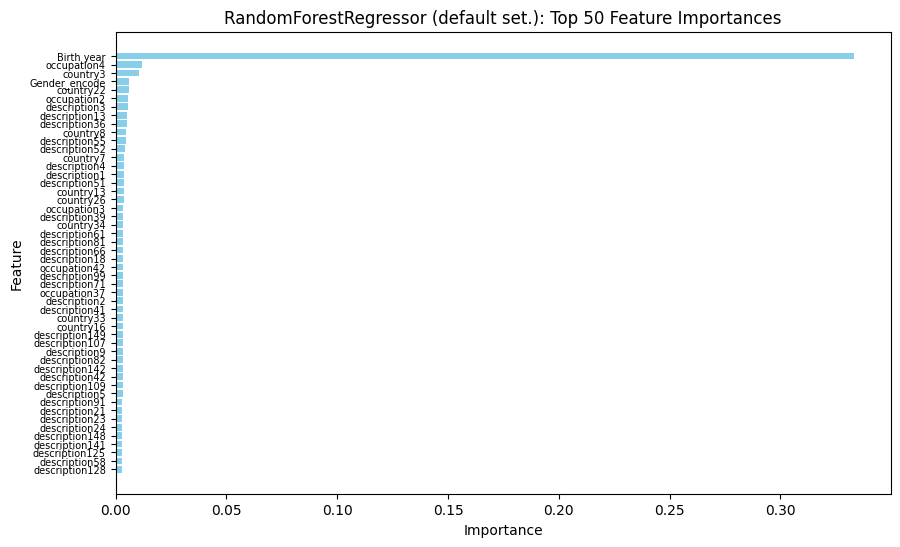

In [70]:
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks(fontsize = 7)
plt.title(f'RandomForestRegressor (default set.): Top {top_n} Feature Importances')
plt.gca().invert_yaxis()
fig = plt.gcf()
plt.show()

In [71]:
fig.savefig('/work/datascience_exam/output/plots/rfr_feature_importances_full_default.jpg')

In [72]:
# We'll only keep relevant features in the model, so we are setting a threshold of 'importance'
selected_features = feature_importances[feature_importances['Importance'] > 0.003] # this is very low threshold
selected_features.shape

(58, 2)

In [73]:
# save features so they are easy to reload if anything crashes
#selected_features.to_csv('/work/datascience_exam/output/models/selected_features_importances.csv')

In [74]:
# get the feature to keep in a list
features_to_keep = selected_features['Feature'].tolist()

# Filter that from X_train
X_train_filtered = X_train[features_to_keep]
X_train_filtered.shape

(510302, 58)

In [75]:
X_train_filtered.to_csv('/work/datascience_exam/data/X_train_filtered.csv', index=False)

In [76]:
# filter validation dataset, too and save
X_val_filtered = X_val[features_to_keep]
X_val_filtered.shape

(109351, 58)

In [77]:
X_val_filtered.to_csv('/work/datascience_exam/data/X_val_filtered.csv', index=False)

In [18]:
# randomforest model with default parameter values - after feature selection # 64 min

rfreg_58_features = RandomForestRegressor(random_state=42)
rfreg_58_features.fit(X_train_filtered, y_train) 

preds = rfreg_58_features.predict(X_val_filtered)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'randomforrest_default_58preds', # 'rfr_default_58_features' old name
                        'split': 'validation',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [19]:
# save model 
pkl.dump(rfreg_58_features, file=open(f'/work/datascience_exam/output/models/rfr_default_58_features.pkl', 'wb')) # save the model

In [78]:
# reload model
rfreg_58_features = pkl.load(open('/work/datascience_exam/output/models/rfr_default_58_features.pkl','rb'))

In [81]:
print(*performances, sep = '\n')

{'model': 'dummy', 'split': 'validation', 'rmse': 15.9833, 'r2': -0.0}
{'model': 'linear-gender', 'split': 'validation', 'rmse': 15.9637, 'r2': 0.0024}
{'model': 'linear-birth_year', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear-full', 'split': 'validation', 'rmse': 15.3703, 'r2': 0.0752}
{'model': 'linear_lasso_alpha_1.0', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear_ridge_alpha_1.0', 'split': 'validation', 'rmse': 15.3702, 'r2': 0.0752}
{'model': 'knn-allpreds-10', 'split': 'validation', 'rmse': 14.5385, 'r2': 0.1726}
{'model': 'randomforest_default_allpreds', 'split': 'validation', 'rmse': 14.1748, 'r2': 0.2135}
{'model': 'randomforrest_default_58preds', 'split': 'validation', 'rmse': 14.205, 'r2': 0.2101}


The model's performance almost didn't decrease even though I removed many of the features,

which is definitely an indication that many of the features are not important.

I'll now make randomized search cross-validation to explore the best combination of parameters while 

constraining the model by introducing 'stopping' parameters. 

This will probably reveal that the only reason that the model is overfitting.

First I'll look at the default parameters of the random forrest model. 


Default parameters:
- 'bootstrap': True,
- 'criterion': 'mse',
- 'max_depth': None,
- 'max_features': 'auto',
- 'max_leaf_nodes': None,
- 'min_impurity_decrease': 0.0,
- 'min_impurity_split': None,
- 'min_samples_leaf': 1,
- 'min_samples_split': 2,
- 'min_weight_fraction_leaf': 0.0,
- 'n_estimators': 10, # default only used 10 trees
- 'n_jobs': 1,
- 'oob_score': False,
- 'random_state': 42,
- 'verbose': 0,
- 'warm_start': False}

In [39]:
# here put full random forrest model 
rfreg_cv = RandomForestRegressor(random_state=42) # first, we instantiate the estimator

In [40]:
param_grid = { 
    'n_estimators': [5, 10, 20, 100, 200], # number of trees - deafult is 100
    'max_depth' : [5, 10, 15, 20], # max number of splits/leaves (leaf = node without children) - stopping criteria # default is none
    'min_samples_split': [2, 5, 10], # min. number of samples required to split an internal node, default is 2
    'max_features': [0.3, 0.6, 0.9], # proportion of features to max. use in a tree (subset proportion) - default is 1.0 (= all features)
    'ccp_alpha': [0.01, 0.1, 1.0] # minimal-cost complexity pruning - to overvoid overfitting, default 0.0 
}

# run with ccp_alpha of 0.5 oe 1.0 - not 0.01

In [ ]:
# MORE CONSTRAINING VERSION
param_grid2 = { 
    'n_estimators': [5, 10, 20, 100, 150], # number of trees - deafult is 100
    'max_depth' : [5, 10, 15, 20], # max number of splits/leaves (leaf = node without children) - stopping criteria # default is none
    'min_samples_split': [2, 5, 10], # min. number of samples required to split an internal node, default is 2
    'max_features': [0.3, 0.6, 0.8], # proportion of features to max. use in a tree (subset proportion) - default is 1.0 (= all features)
    'ccp_alpha': [0.4, 0.6, 1.0] # minimal-cost complexity pruning - to overvoid overfitting, default 0.0 
}

# run with ccp_alpha of 0.5 oe 1.0 - not 0.01

In [41]:
# cv - ~90 min 
cv_rfr = RandomizedSearchCV(estimator=rfreg_cv, # I am choosing RandomizedSearchCV for speed
                            param_distributions=param_grid2,
                            scoring='neg_root_mean_squared_error', # this is "neg" because CV wants a metric to maximize
                            n_iter=10, # this should more likely be above 100, and in general the higher the better
                            cv=5,
                            verbose = 2,
                            n_jobs = -1)

randomized_search = cv_rfr.fit(X_train_filtered, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ccp_alpha=1.0, max_depth=5, max_features=0.3, min_samples_split=2, n_estimators=10; total time=  30.3s
[CV] END ccp_alpha=1.0, max_depth=5, max_features=0.3, min_samples_split=2, n_estimators=10; total time=  39.7s
[CV] END ccp_alpha=1.0, max_depth=5, max_features=0.3, min_samples_split=2, n_estimators=10; total time=  39.6s
[CV] END ccp_alpha=1.0, max_depth=5, max_features=0.3, min_samples_split=2, n_estimators=10; total time=  40.2s
[CV] END ccp_alpha=1.0, max_depth=5, max_features=0.3, min_samples_split=2, n_estimators=10; total time=  40.2s
[CV] END ccp_alpha=0.01, max_depth=5, max_features=0.3, min_samples_split=5, n_estimators=20; total time=  57.2s
[CV] END ccp_alpha=0.01, max_depth=5, max_features=0.3, min_samples_split=5, n_estimators=20; total time= 1.1min
[CV] END ccp_alpha=0.01, max_depth=5, max_features=0.3, min_samples_split=5, n_estimators=20; total time= 1.1min
[CV] END ccp_alpha=0.01, max_depth=5, ma

In [42]:
# save 
pkl.dump(randomized_search, file=open(f'/work/datascience_exam/output/models/randomized_search_cv_58_features.pkl', 'wb')) # save the model

In [82]:
# re-load model 
randomized_search= pkl.load(open('/work/datascience_exam/output/models/randomized_search_cv_58_features.pkl','rb'))

In [ ]:
randomized_search.cv_results_

In [83]:
randomized_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'max_features': 0.9,
 'max_depth': 10,
 'ccp_alpha': 0.01}

In [15]:
#best_params = randomized_search.best_params_

The model maximizes the number of trees, but doesn't maximize tree depth. 
min_smaples_split is also maximized, which should reduce overfitting.
almost all features are used in a tree 
ccp_alpha should maybe be higher.. 

Now we want to test the tuned model on the validation data 

In [84]:
cv_rfr_tuned = randomized_search.best_estimator_ # has already been fitted

preds = cv_rfr_tuned.predict(X_val_filtered)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'randomforest_tuned_58preds', 
                        'split': 'validation',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [53]:
pkl.dump(cv_rfr_tuned, file=open(f'/work/datascience_exam/output/models/cv_rfr_tuned_58_features.pkl', 'wb')) # save the model

In [91]:
print(*performances, sep = '\n')

{'model': 'dummy', 'split': 'validation', 'rmse': 15.9833, 'r2': -0.0}
{'model': 'linear-gender', 'split': 'validation', 'rmse': 15.9637, 'r2': 0.0024}
{'model': 'linear-birth_year', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear-full', 'split': 'validation', 'rmse': 15.3703, 'r2': 0.0752}
{'model': 'linear_lasso_alpha_1.0', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear_ridge_alpha_1.0', 'split': 'validation', 'rmse': 15.3702, 'r2': 0.0752}
{'model': 'knn-allpreds-10', 'split': 'validation', 'rmse': 14.5385, 'r2': 0.1726}
{'model': 'randomforest_default_allpreds', 'split': 'validation', 'rmse': 14.1748, 'r2': 0.2135}
{'model': 'randomforest_default_58preds', 'split': 'validation', 'rmse': 14.205, 'r2': 0.2101}
{'model': 'randomforrest_tuned_58preds', 'split': 'validation', 'rmse': 13.8965, 'r2': 0.2441}


In [86]:
# It's time to test the test data. First we need to select the correct features
X_test_filtered = X_test[features_to_keep]
X_test_filtered.shape

(109351, 58)

In [4]:
# The final test; predicting test data

preds = cv_rfr_tuned.predict(X_test_filtered)
r2 = r2_score(y_test, preds)
performance = np.sqrt(mean_squared_error(y_test, preds))
performances.append({'model': 'randomforrest_tuned_58preds', 
                        'split': 'test',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})


In [ ]:
print(*performances, sep = '\n')

/tmp/ipykernel_315/2933745057.py:3: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False),


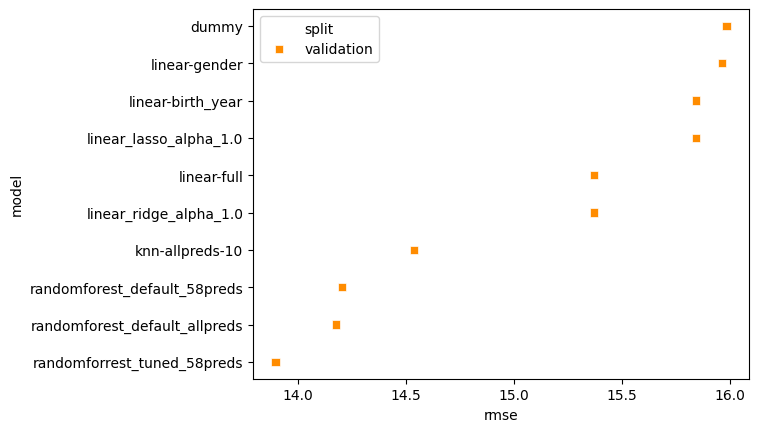

In [92]:
# plotting performances
perf_df = pd.DataFrame(performances)
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', 
                palette=['darkorange', 'grey', 'darkred'])
fig = plt.gcf() # get current figure
plt.show()

In [73]:
fig.savefig('/work/datascience_exam/output/plots/performances.jpg', bbox_inches='tight')

In [27]:
perf_df.to_csv('/work/datascience_exam/output/models/model_performances_v5.csv')

That's it! 

### When starting and stopping midway
The code below if for loading the performances into a dictionary, so the dictionary is nice and neat

Eases plotting etc

In [ ]:
# how to read df into a dictionary
df = pd.read_csv('/work/datascience_exam/output/models/model_performances_v3.csv', index_col = 0)

# make into list format
performances = []

for index, row in df.iterrows():
    row_dict = {}
    for col in df.columns:
        row_dict[col] = row[col]
    performances.append(row_dict)

print(*performances, sep = '\n')

### Feature selection

In [30]:
from matplotlib import pyplot
from sklearn.feature_selection import f_regression, SelectKBest


In [73]:
type(X_train)

pandas.core.frame.DataFrame

In [69]:
# feature selection using f_regression

def select_features(X_train, y_train, k_no):
    # configure to select all features or a number
    fs = SelectKBest(score_func=f_regression, k= k_no)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    #X_test_fs = fs.transform(X_test)
    return X_train_fs, fs 

In [70]:
X_train_fs, fs = select_features(X_train, y_train, 10) # k = 'all' or chose x number of most important features

Feature 0: 1225.239204
Feature 1: 9921.619780
Feature 2: 2146.231520
Feature 3: 50.099816
Feature 4: 1304.764435
Feature 5: 467.370930
Feature 6: 5787.824785
Feature 7: 511.984302
Feature 8: 118.964952
Feature 9: 121.330197
Feature 10: 141.533798
Feature 11: 249.523181
Feature 12: 73.704463
Feature 13: 5.921109
Feature 14: 114.263532
Feature 15: 821.729485
Feature 16: 160.749735
Feature 17: 8.369026
Feature 18: 5.706026
Feature 19: 249.385076
Feature 20: 2.814521
Feature 21: 52.674707
Feature 22: 144.499804
Feature 23: 111.522017
Feature 24: 594.015891
Feature 25: 234.342221
Feature 26: 237.779519
Feature 27: 4.289003
Feature 28: 2.158343
Feature 29: 3.809985
Feature 30: 552.635925
Feature 31: 3.353557
Feature 32: 26.595922
Feature 33: 5.952956
Feature 34: 7.538964
Feature 35: 172.424523
Feature 36: 35.717541
Feature 37: 15.738743
Feature 38: 14.385934
Feature 39: 60.409047
Feature 40: 2.908049
Feature 41: 354.048050
Feature 42: 307.741966
Feature 43: 236.742005
Feature 44: 566.811591


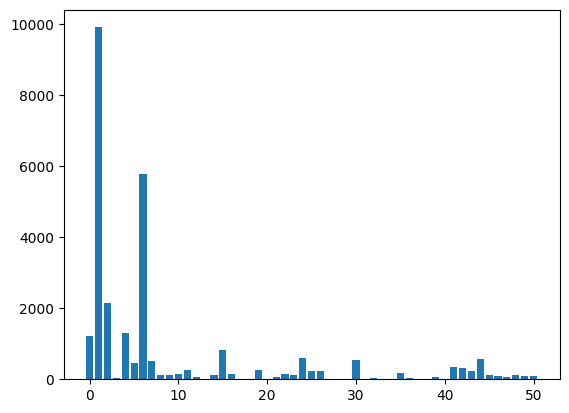

In [71]:
# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [72]:
X_train_fs.shape

(515049, 10)

### Lasso feature selection

As expected, it would be a good idea to do some feature selection. 
I'll do that using lasso

In [31]:
#from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel


In [75]:

lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
model = SelectFromModel(lasso, prefit=True)
X_train_selected = model.transform(X_train)


/work/datascience_exam/env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [37]:
importances.shape
importances = randomized_search.best_estimator_.feature_importances_


(51,)

In [38]:
# try that with randomized forrest? 
model = SelectFromModel(cv_rfr_tuned, prefit=True, importance_getter = 'feature_importances_') # try this


In [39]:
X_train_selected = model.transform(X_train)
#X_train_seelcted.shape

/work/datascience_exam/env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [41]:
X_train_selected

array([[1802, 0.03634738177061081],
       [1884, -0.018077649176120758],
       [1896, -0.0037354351952672005],
       ...,
       [1876, -0.018253348767757416],
       [1928, -0.00385521468706429],
       [1860, -0.07332148402929306]], dtype=object)

In [ ]:
# fit the model again
rfr_default = RandomForestRegressor(random_state=42)
rfr_default_fitted = rfr_default.fit(X_train_selected, y_train)

preds = rfr_default_fitted.predict(X_train_selected)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
#performances.append({'model': 'rfr_default_feat_select',
#                        'split': 'train',
#                         'rmse': performance.round(4),
#                         'r2': r2.round(4)})


In [45]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 15.9491, 'r2': 0.0},
 {'model': 'linear-gender', 'rmse': 15.9302, 'r2': 0.0024},
 {'model': 'linear-birth_year', 'rmse': 15.7977, 'r2': 0.0189},
 {'model': 'linear-full', 'rmse': 15.5663, 'r2': 0.0474},
 {'model': 'linear_lasso_alpha_1.0', 'rmse': 15.769, 'r2': 0.0225},
 {'model': 'linear_ridge_alpha_1.0', 'rmse': 15.5663, 'r2': 0.0474},
 {'model': 'knn-allpreds-10', 'split': 'train', 'rmse': 14.5307, 'r2': 0.17},
 {'model': 'rfr_default', 'rmse': 13.2268, 'r2': 0.3122},
 {'model': 'random_forrest_tuned2',
  'split': 'train',
  'rmse': 13.4915,
  'r2': 0.2844},
 {'model': 'rfr_default_feat_select',
  'split': 'train',
  'rmse': 13.5097,
  'r2': 0.2825}]

In [ ]:
{'n_estimators': 100,
 'min_samples_split': 5,
 'max_features': 0.6,
 'max_depth': 10,
 'ccp_alpha': 0.01}

In [28]:
cv_rfr.best_estimator_.get_params()

{'bootstrap': True, 'ccp_alpha': 0.01, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 0.6, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

In [ ]:
cv_rfr.best_estimator_